# Transfer Learning for Glacier Mass Balance Prediction

This notebook demonstrates **transfer learning** between glacier mass balance models trained on different regions. Specifically, we:

1. **Load a pre-trained neural network** trained on Swiss glacier data
2. **Fine-tune it on French glacier data** using various strategies
3. **Evaluate performance** on unseen French glaciers

## Key Features
- **Progressive layer unfreezing** for gradual adaptation
- **Multiple train/test split strategies** (50%, North/South, 5-10%)
- **Comprehensive evaluation metrics** and visualizations
- **Model checkpointing** at specific epochs for analysis

---

## Prerequisites
- Pre-trained model on all Swiss data from ../regions/Switzerland/3.2.2 Train-ML-model-NN.ipynb e.g. `nn_model_2025-07-14_CH_flexible.pt`
- French glacier dataset from ../regions/France/1.1. GLACIOCLIM-prepro.ipynb
- ERA5 climate data of France from ../regions/France/1.2. ERA5Land-prepro.ipynb

---

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *


warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.FranceConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## Data Loading & Preprocessing

### Create French Glacier Dataset
We start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [4]:
data_glacioclim = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm_with_blanc.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
#print('Number of summer samples:',
      #len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))

data_glacioclim = data_glacioclim[data_glacioclim['PERIOD'] != 'summer']

data_glacioclim.columns


Number of glaciers: 9
Number of winter, summer and annual samples: 10762
Number of annual samples: 4785
Number of winter samples: 3281


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE', 'YEAR',
       'DATA_MODIFICATION', 'RGIId', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

In [5]:
data_glacioclim_test = data_glacioclim.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'FR_wgms_dataset_monthly_full_no_summer_with_blanc.csv')
data_monthly = dataloader_gl.data

2025-09-01 11:05:52,331 - INFO - Loaded preprocessed data.
2025-09-01 11:05:52,332 - INFO - Number of monthly rows: 81534
2025-09-01 11:05:52,343 - INFO - Number of annual samples: 57592
2025-09-01 11:05:52,350 - INFO - Number of winter samples: 23942


## Train/Test Split Strategies

Implement three different strategies for splitting the French data to test various transfer learning scenarios:

### Strategy 1: 50% Random Split
**Data**: This hasnt been done yet for France

**Use case**: Balanced representation with good data availability for transfer learning adaptation.

In [22]:
# TRANSFER LEARNING SETUP 50%
train_glaciers = []

# Test glaciers (all remaining Norway glaciers)
all_norway_glaciers = list(data_glacioclim['GLACIER'].unique())
test_glaciers = [g for g in all_norway_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))


Fine-tuning glaciers (0): []
Test glaciers (8): ['FR4N01235A08 dArgentiere', 'FR4N01146D09+E06 Gebroulaz', 'FR4N01236A01 Mer de Glace/Geant', 'FR4N01236A01 Leschaux', 'FR4N01236A07 de Talefre', 'FR4N01163A02 de Sarennes 1', 'FR4N01162B09+154D03 de Saint Sorlin', 'FR4N01236A02 des Grands Montets']


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.

### Strategy 2: East/West Geographic Split

**Data:** This hasnt been done yet

**Use case**: Test geographic generalization across longitudinal gradients.

In [ ]:
# Get glacier latitudes
glacier_lat = data_glacioclim.groupby('GLACIER')['POINT_LAT'].first()

# Use the median latitude as the split
lat_threshold = glacier_lat.median()

north_glaciers = glacier_lat[glacier_lat >= lat_threshold].index.tolist()
south_glaciers = glacier_lat[glacier_lat < lat_threshold].index.tolist()

print(f"North glaciers ({len(north_glaciers)}): {north_glaciers}")
print(f"South glaciers ({len(south_glaciers)}): {south_glaciers}")

North glaciers (16): ['Aalfotbreen', 'Austdalsbreen', 'Blaaisen', 'Cainhavarre', 'Engabreen', 'Hansebreen', 'Harbardsbreen', 'Hoegtuvbreen', 'Juvfonne', 'Nigardsbreen', 'Rundvassbreen', 'Storglombreen N', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Vesledalsbreen']
South glaciers (15): ['Austre Memurubreen', 'Blabreen', 'Blomstoelskardsbreen', 'Bondhusbrea', 'Breidablikkbrea', 'Graafjellsbrea', 'Graasubreen', 'Hellstugubreen', 'Moesevassbrea', 'Rembesdalskaaka', 'Ruklebreen', 'Svelgjabreen', 'Tunsbergdalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']


In [ ]:
# North/south at median, train is south set 50%
train_glaciers = []

# Test glaciers (all remaining Norway glaciers)
all_norway_glaciers = list(data_glacioclim['GLACIER'].unique())
test_glaciers = [g for g in all_norway_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))

Fine-tuning glaciers (15): ['Austre Memurubreen', 'Blabreen', 'Blomstoelskardsbreen', 'Bondhusbrea', 'Breidablikkbrea', 'Graafjellsbrea', 'Graasubreen', 'Hellstugubreen', 'Moesevassbrea', 'Rembesdalskaaka', 'Ruklebreen', 'Svelgjabreen', 'Tunsbergdalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']
Test glaciers (16): ['Rundvassbreen', 'Engabreen', 'Aalfotbreen', 'Hansebreen', 'Nigardsbreen', 'Austdalsbreen', 'Juvfonne', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Harbardsbreen', 'Storglombreen N', 'Blaaisen', 'Cainhavarre', 'Vesledalsbreen', 'Hoegtuvbreen']
Train glaciers: (15) ['Hellstugubreen' 'Rembesdalskaaka' 'Svelgjabreen' 'Blomstoelskardsbreen'
 'Moesevassbrea' 'Vetlefjordbreen' 'Graafjellsbrea' 'Breidablikkbrea'
 'Graasubreen' 'Blabreen' 'Ruklebreen' 'Tunsbergdalsbreen'
 'Austre Memurubreen' 'Vestre Memurubreen' 'Bondhusbrea']
Test glaciers: (16) ['Rundvassbreen' 'Engabreen' 'Aalfotbreen' 'Hansebreen' 'Nigardsbreen'
 'Austdalsbreen' 'Juvfonne' 'Storsteinsfj

'length train set'

13698

'length test set'

43267

### Strategy 3: Limited Data Split (5-10% for fine-tuning)

**Data**: About 5-10 % of the available data is used as fine-tuning set, consisting of 4 glaciers.

**Use case**: Test performance with minimal fine-tuning data (~500 measurements) to simulate data-scarce scenarios.

In [6]:
# TRANSFER LEARNING SETUP 5-10%
# Fine-tuning glaciers 5-10%
train_glaciers = ['FR4N01163A02 de Sarennes 1', 'FR4N01236A07 de Talefre', 'FR4N01236A02 des Grands Montets', 'FR4N01236A01 Leschaux']

# Test glaciers (all remaining France glaciers)
all_france_glaciers = list(data_glacioclim['GLACIER'].unique())
test_glaciers = [g for g in all_france_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))

Fine-tuning glaciers (4): ['FR4N01163A02 de Sarennes 1', 'FR4N01236A07 de Talefre', 'FR4N01236A02 des Grands Montets', 'FR4N01236A01 Leschaux']
Test glaciers (5): ['FR4N01235A08 dArgentiere', 'FR4N01146D09+E06 Gebroulaz', 'FR4N01083B21 Blanc', 'FR4N01236A01 Mer de Glace/Geant', 'FR4N01162B09+154D03 de Saint Sorlin']
Train glaciers: (4) ['FR4N01236A01 Leschaux' 'FR4N01236A07 de Talefre'
 'FR4N01163A02 de Sarennes 1' 'FR4N01236A02 des Grands Montets']
Test glaciers: (5) ['FR4N01235A08 dArgentiere' 'FR4N01146D09+E06 Gebroulaz'
 'FR4N01083B21 Blanc' 'FR4N01236A01 Mer de Glace/Geant'
 'FR4N01162B09+154D03 de Saint Sorlin']


'length train set'

6468

'length test set'

75066

## Validation Split Options

Use the same Option as was used for the Swiss model.

### Option 1: Random 80/20 Split
**Recommended for**: General model validation with balanced representation across all fine-tuning glaciers.

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train data glacier distribution: GLACIER
FR4N01236A01 Leschaux              2409
FR4N01236A07 de Talefre            2251
FR4N01163A02 de Sarennes 1          459
FR4N01236A02 des Grands Montets      81
Name: count, dtype: int64
Val data glacier distribution: GLACIER
FR4N01236A01 Leschaux              567
FR4N01236A07 de Talefre            483
FR4N01163A02 de Sarennes 1         191
FR4N01236A02 des Grands Montets     27
Name: count, dtype: int64
Train data shape: (5200, 29)
Val data shape: (1268, 29)


### Option 2: Glacier-wise Train/Val Split
**Recommended for**: Testing glacier-level generalization by validating on a completely unseen glacier during fine-tuning.

### This hasnt been implemented yet

In [ ]:
# Glacier-wise train/val split: validate on Engabreen, train on the other 3
data_train = train_set['df_X']
data_train['y'] = train_set['y']

val_glacier = ['Engabreen']
train_glaciers = [g for g in train_glaciers if g not in val_glacier]

df_X_train = data_train[data_train['GLACIER'].isin(train_glaciers)].copy()
y_train = df_X_train['POINT_BALANCE'].values

df_X_val = data_train[data_train['GLACIER'].isin(val_glacier)].copy()
y_val = df_X_val['POINT_BALANCE'].values

print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

## Neural Network Configuration

### Feature Engineering and Dataset Preparation

In [8]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate)

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (5200, 28)
Shape of validation dataset: (1268, 28)
Shape of testing dataset: (75066, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


### Model Callbacks and Training Configuration
Set up training callbacks and configuration for optimal performance and monitoring.

In [9]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='valid_loss',    # Monitor validation loss
    patience=15,             # Stop after 15 epochs without improvement
    threshold=1e-4,          # Minimum change threshold
)

# Learning rate scheduler for adaptive training
lr_scheduler_cb = LRScheduler(
    policy=ReduceLROnPlateau,
    monitor='valid_loss',
    mode='min',
    factor=0.5,              # Reduce LR by half
    patience=5,              # Wait 5 epochs before reducing
    threshold=0.01,
    threshold_mode='rel',
    verbose=True
)

# Global variables for dataset management
dataset = dataset_val = None

def my_train_split(ds, y=None, **fit_params):
    """Custom train/validation split function for skorch."""
    return dataset, dataset_val

# Model configuration parameters
param_init = {'device': 'cpu'}
nInp = len(feature_columns)  # Number of input features

# Model checkpointing to save best model during training
checkpoint_cb = Checkpoint(
    monitor='valid_loss_best',
    f_params='best_model.pt',
    f_optimizer=None,        # Don't save optimizer state
    f_history=None,          # Don't save training history
    f_criterion=None,        # Don't save criterion state
    load_best=True,          # Load best model after training
)

# Custom callback to save models at specific epochs for analysis
save_best_epochs_cb = SaveBestAtEpochs([10, 15, 20, 30, 50, 100])

print('Callbacks and configuration ready!')

Callbacks and configuration ready!


### Dataset Creation
Datasets will be created in the training loop after loading the pre-trained Swiss model to ensure compatible preprocessing.

In [10]:
# Don't create datasets here, create them after loading the Swiss model
features = features_val = None
metadata = metadata_val = None
dataset = dataset_val = None
print("Datasets will be created after loading Swiss model...")

Datasets will be created after loading Swiss model...


## Transfer Learning Execution

### Loading Pre-trained Swiss Model and Fine-tuning on French Data

### Method 1: Standard Fine-tuning with Selective Layer Freezing

After loading the model, all layers will be frozen by default, to unfreeze a layer you have to include it in "if name not in [...]" in Step 3.

 The SaveBestAtEpochs callback automatically saves the current best model at epochs [10, 15, 20, 30, 50, 100], which can then be evaluated in the Epoch-wise model evalution section. Comment out the callback if you don't want this feature. If you do and you continuously want to retrain models at different learning rates, you have to reexecute the "save_best_epochs_cb = SaveBestAtEpochs([10, 15, 20, 30, 50, 100])" cell.

In [11]:
TRAIN = True  # Set to True to actually train
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model FIRST
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True, # Important!!! this tells skorch to not re-initialize the weights etc.
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
            #('save_best_at_epochs', save_best_epochs_cb)
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )

    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using the loaded Swiss model
    print("Creating datasets with Swiss model...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(
        SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
    
    print("train:", dataset.X.shape, dataset.y.shape)
    print("validation:", dataset_val.X.shape, dataset_val.y.shape)


    # STEP 2.5: Freeze layers
    for name, param in loaded_model.module_.named_parameters():
        # Freeze layers
        if name not in [#'model.0.weight', 'model.0.bias',
                        'model.1.weight', 'model.1.bias',
                        #'model.4.weight', 'model.4.bias',
                        'model.5.weight', 'model.5.bias',
                        #'model.8.weight', 'model.8.bias',
                        'model.9.weight', 'model.9.bias',
                        #'model.12.weight', 'model.12.bias',
                        'model.13.weight', 'model.13.bias',
                        #'model.16.weight', 'model.16.bias'
                        ]:
            param.requires_grad = False
    
    # STEP 3: Update for fine-tuning
    print("Updating model for fine-tuning...")
    loaded_model = loaded_model.set_params(
        lr=0.05,
        max_epochs=200,
    )
    
    # STEP 4: Fine-tune
    print("Starting fine-tuning...")
    loaded_model.fit(features, y_train)
    
    # STEP 5: Save
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")



Loading pre-trained Swiss model...
✓ Swiss model loaded successfully!
Creating datasets with Swiss model...
train: (522,) (522,)
validation: (131,) (131,)
Updating model for fine-tuning...
Starting fine-tuning...
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1        2.2903        9.8940     +  0.0500  0.2430
      2        1.3045        6.4298     +  0.0500  0.2351
      3        1.2511        1.0712     +  0.0500  0.2342
      4        0.6524        0.4270     +  0.0500  0.2368
      5        0.6746        0.3777     +  0.0500  0.2409
      6        0.5788        0.3970        0.0500  0.2342
      7        0.5675        0.7898        0.0500  0.2333
      8        0.5296        0.4299        0.0500  0.2326
      9        0.5648        0.3400     +  0.0500  0.2336
     10        0.5554        0.3541        0.0500  0.2374
     11        0.4656        0.4247        0.0500  0.2321
     12        0.4962        0.47

### Method 2: Progressive Layer Unfreezing
This advanced approach gradually unfreezes layers during training for more controlled adaptation to the French data.

In [ ]:
TRAIN = True  # Set to True to actually train
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model FIRST
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True, # Important!!! this tells skorch not re-initialize the weights etc.
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )

    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using the loaded Swiss model
    print("Creating datasets with Swiss model...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(
        SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
    
    print("train:", dataset.X.shape, dataset.y.shape)
    print("validation:", dataset_val.X.shape, dataset_val.y.shape)


    # STEP 2.5: Freeze layers
    
    # Helper to freeze/unfreeze layers
    def set_requires_grad(layer_names, requires_grad=True):
        for name, param in loaded_model.module_.named_parameters():
            if name in layer_names:
                param.requires_grad = requires_grad

    # List of layer groups to progressively unfreeze
    layer_groups = [
        (
        [
            'model.1.weight', 'model.1.bias',
            'model.5.weight', 'model.5.bias',
            'model.9.weight', 'model.9.bias',
            'model.13.weight', 'model.13.bias'
        ],200,  0.1
    ),
        (['model.16.weight', 'model.16.bias'], 200, 0.001),
        (['model.12.weight', 'model.12.bias'], 200, 0.001),
        (['model.8.weight', 'model.8.bias'], 200, 0.001)
    ]

    # Freeze all layers first
    for name, param in loaded_model.module_.named_parameters():
        param.requires_grad = False

    # Progressive unfreezing loop with custom learning rates
    for layers, epochs, lr in layer_groups:
        set_requires_grad(layers, True)
        print(f"Fine-tuning layers: {layers} for {epochs} epochs with lr={lr}...")
        loaded_model = loaded_model.set_params(lr=lr, max_epochs=epochs)
        loaded_model.fit(features, y_train)

        val_score = loaded_model.score(dataset_val.X, dataset_val.y)
        print("Validation score:", val_score)
    
    # STEP 3: Save
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")



### Model Evaluation

#### Quick Performance Evaluation
Get immediate performance metrics on the test set using the fine-tuned model.

In [12]:
# Quick comprehensive evaluation of the fine-tuned model
print("Evaluating fine-tuned model performance...")

grouped_ids, scores_NN, ids_NN, y_pred_NN = evaluate_model_and_group_predictions(
    loaded_model, df_X_test_subset, test_set['y'], cfg, mbm
)

print("Test Set Performance Metrics:")
display(scores_NN)

# Validation score for confirmation that model with the best val_loss is used
val_score = loaded_model.score(dataset_val.X, dataset_val.y)
print(f"Validation score (for reference): {val_score:.4f}")

# Calculate additional performance metrics by glacier
print("\nPerformance by glacier:")
glacier_performance = grouped_ids.groupby('GLACIER').apply(
    lambda x: pd.Series({
        'n_samples': len(x),
        'rmse': np.sqrt(np.mean((x['target'] - x['pred'])**2)),
        'mae': np.mean(np.abs(x['target'] - x['pred'])),
        'r2': 1 - np.sum((x['target'] - x['pred'])**2) / np.sum((x['target'] - x['target'].mean())**2)
    })
).round(4)

display(glacier_performance.sort_values('rmse'))

Evaluating fine-tuned model performance...
Test Set Performance Metrics:


{'score': -0.9183062414920519,
 'mse': 0.9183062417162868,
 'rmse': 0.9582829653689389,
 'mae': 0.6871042668310513,
 'pearson': 0.9229873140357064}

Validation score (for reference): -0.2765

Performance by glacier:


,n_samples,rmse,mae,r2
GLACIER,,,,
FR4N01162B09+154D03 de Saint Sorlin,2163.0,0.7147,0.5348,0.8422
FR4N01146D09+E06 Gebroulaz,1285.0,0.7846,0.5642,0.8060
FR4N01235A08 dArgentiere,2513.0,0.8853,0.6681,0.8499
FR4N01236A01 Mer de Glace/Geant,1185.0,1.1352,0.8098,0.9103
FR4N01083B21 Blanc,267.0,2.3019,2.1468,-1.0757


#### Epoch-wise Model Evaluation
Evaluate models saved at different training epochs to understand training dynamics and optimal stopping points.

In [ ]:
# Evaluate models saved at different epochs to analyze training dynamics
print("Evaluating models saved at different training epochs...")

epochs_to_evaluate = [10, 15, 20, 30, 50, 100]
model_prefix = "nn_model_best_epoch"

epoch_results = {}

for epoch in epochs_to_evaluate:
    model_name = f"{model_prefix}_{epoch}.pt"
    
    # Check if model file exists
    if not os.path.exists(model_name):
        print(f"Model for epoch {epoch} not found, skipping...")
        continue

    print(f"Evaluating model at epoch {epoch}...")
    
    # Load model with same architecture as Swiss model
    epoch_model = mbm.models.CustomNeuralNetRegressor(
        cfg, **swiss_args, **param_init
    )
    epoch_model = epoch_model.set_params(device='cpu').to('cpu')
    epoch_model.initialize()
    
    # Load saved weights
    state_dict = torch.load(model_name, map_location='cpu')
    epoch_model.module_.load_state_dict(state_dict)

    # Evaluate the model
    grouped_ids_epoch, scores_NN_epoch, ids_NN_epoch, y_pred_NN_epoch = evaluate_model_and_group_predictions(
        epoch_model, df_X_test_subset, test_set['y'], cfg, mbm
    )
    
    # Store results
    epoch_results[epoch] = scores_NN_epoch
    
    print(f"Epoch {epoch} performance:")
    display(scores_NN_epoch)
    print("-" * 50)

print("Epoch-wise evaluation completed!")

# Compare performance across epochs
if epoch_results:
    print("\nPerformance comparison across epochs:")
    comparison_df = pd.DataFrame(epoch_results).T
    comparison_df.index.name = 'Epoch'
    display(comparison_df.round(4))

#### Comprehensive Visualization and Analysis
Generate detailed visualizations to understand model performance across different glaciers and time periods.

In [13]:
# Prepare comprehensive visualization data
print("Preparing data for comprehensive visualizations...")

# Create features and metadata for final evaluation
features_test, metadata_test = loaded_model._create_features_metadata(df_X_test_subset)

# Ensure all tensors are on CPU for visualization
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()
if hasattr(test_set['y'], 'cpu'):
    targets_test = test_set['y'].cpu()
else:
    targets_test = test_set['y']

# Create final test dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),  # Features
    SliceDataset(dataset_test, idx=1)   # Targets
]

# Generate final predictions
print("Generating final predictions for visualization...")
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

# Prepare evaluation metrics
batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate comprehensive performance metrics
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

print(f"Final Model Performance Summary:")
print(f"   R² Score: {score:.4f}")
print(f"   RMSE: {rmse:.4f} mm w.e.")
print(f"   MAE: {mae:.4f} mm w.e.")
print(f"   Pearson r: {pearson:.4f}")

# Create comprehensive results DataFrame
id = dataset_test[0].dataset.indexToId(batchIndex)
grouped_ids = pd.DataFrame({
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
})

# Add comprehensive metadata
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

print("Visualization data prepared successfully!")

Preparing data for comprehensive visualizations...
Generating final predictions for visualization...
Final Model Performance Summary:
   R² Score: -0.9183
   RMSE: 0.9583 mm w.e.
   MAE: 0.6871 mm w.e.
   Pearson r: 0.9230
Visualization data prepared successfully!


Creating comprehensive visualizations...
   Generating time series predictions by glacier...
   Creating prediction vs. truth scatter plot...
   Generating individual glacier performance analysis...
All visualizations generated successfully!

Detailed Performance Summary by Glacier:
Performance by glacier (sorted by RMSE):


,N_samples,RMSE,MAE,R²,Pearson,Target_mean,Target_std
GLACIER,,,,,,,
FR4N01162B09+154D03 de Saint Sorlin,2163,0.7147,0.5348,0.8422,0.9332,-0.4864,1.7997
FR4N01146D09+E06 Gebroulaz,1285,0.7846,0.5642,0.8060,0.9115,-0.3350,1.7820
FR4N01235A08 dArgentiere,2513,0.8853,0.6681,0.8499,0.9307,-0.8150,2.2854
FR4N01236A01 Mer de Glace/Geant,1185,1.1352,0.8098,0.9103,0.9650,-2.0811,3.7912
FR4N01083B21 Blanc,267,2.3019,2.1468,-1.0757,0.8361,-0.8005,1.6007


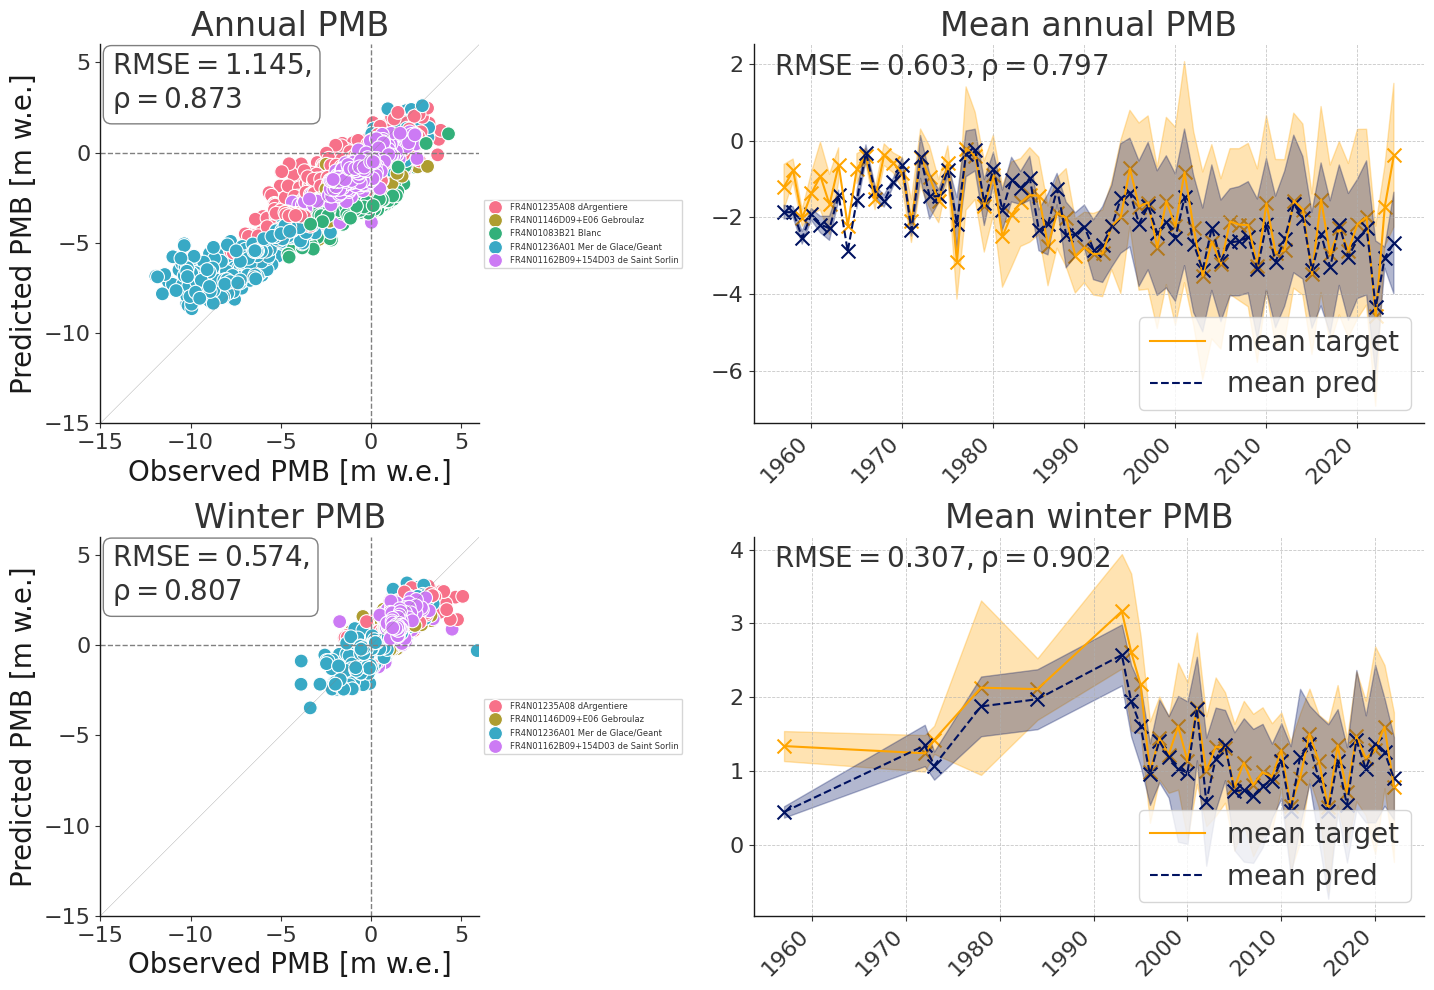

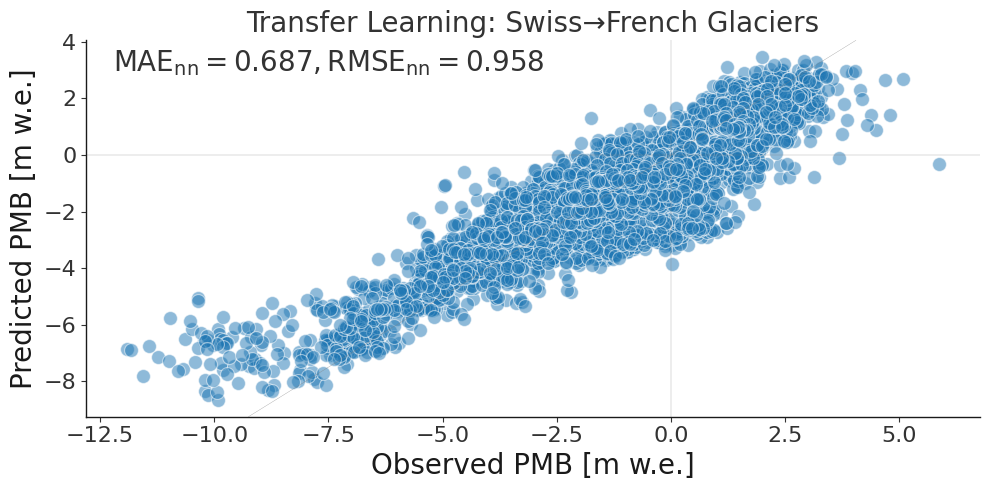

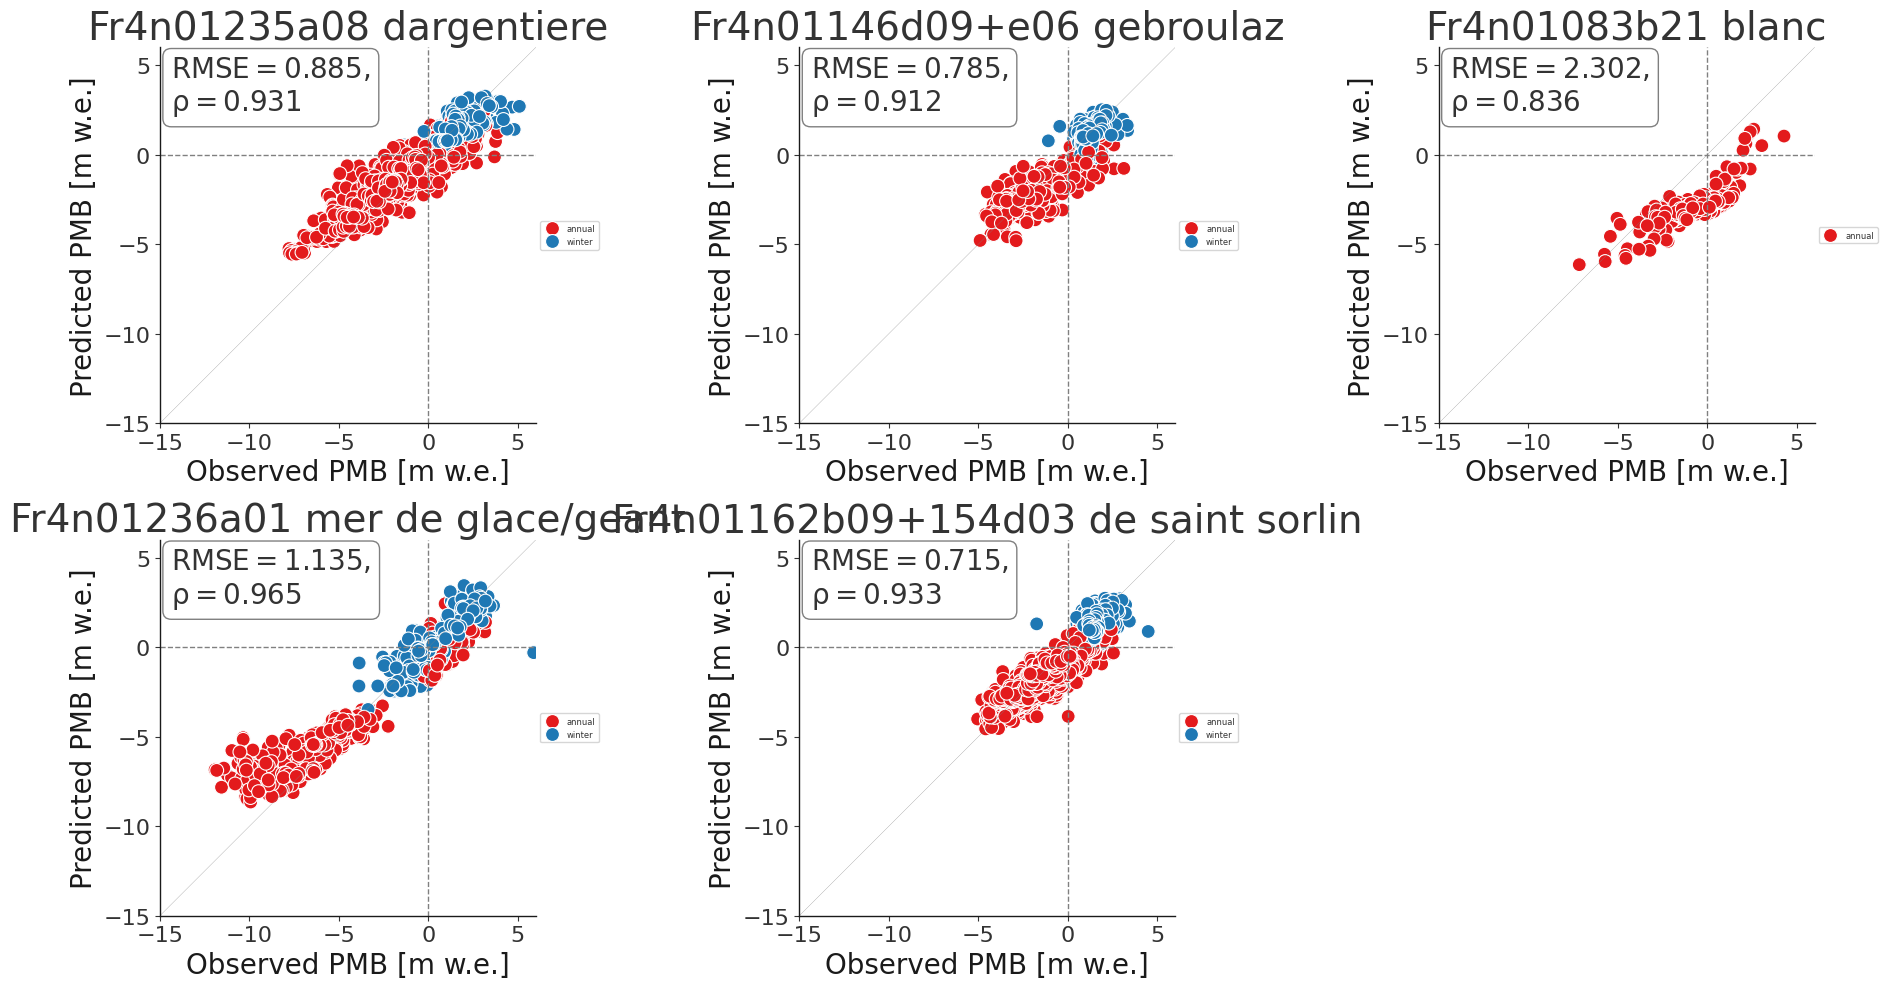

In [14]:

# Generate comprehensive publication-ready visualizations
print("Creating comprehensive visualizations...")

# 1. Time series predictions by glacier
print("   Generating time series predictions by glacier...")
PlotPredictions_NN(grouped_ids)

# 2. Predicted vs. observed scatter plot with performance metrics
print("   Creating prediction vs. truth scatter plot...")
predVSTruth_all(grouped_ids, mae, rmse, title='Transfer Learning: Swiss→French Glaciers')

# 3. Individual glacier performance analysis
print("   Generating individual glacier performance analysis...")
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

print("All visualizations generated successfully!")

# Summary statistics by glacier for detailed analysis
print("\nDetailed Performance Summary by Glacier:")
glacier_stats = grouped_ids.groupby('GLACIER').agg({
    'target': ['count', 'mean', 'std'],
    'pred': ['mean', 'std']
}).round(4)

# Calculate RMSE and MAE per glacier
glacier_rmse = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.sqrt(np.mean((x['target'] - x['pred'])**2))
).round(4)

glacier_mae = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.mean(np.abs(x['target'] - x['pred']))
).round(4)

glacier_r2 = grouped_ids.groupby('GLACIER').apply(
    lambda x: 1 - np.sum((x['target'] - x['pred'])**2) / np.sum((x['target'] - x['target'].mean())**2)
).round(4)

glacier_rho = grouped_ids.groupby('GLACIER').apply(
    lambda x: x['target'].corr(x['pred'])
).round(4)

# Combine all metrics
performance_summary = pd.DataFrame({
    'N_samples': glacier_stats[('target', 'count')],
    'RMSE': glacier_rmse,
    'MAE': glacier_mae,
    'R²': glacier_r2,
    'Pearson': glacier_rho,
    'Target_mean': glacier_stats[('target', 'mean')],
    'Target_std': glacier_stats[('target', 'std')]
}).sort_values('RMSE')

print("Performance by glacier (sorted by RMSE):")
display(performance_summary)